In [3]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path 
import sys 
import os 
import logging
import seaborn as sns
from decimal import Decimal, ROUND_DOWN
import ast 

from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, GroupShuffleSplit
from sklearn.metrics import make_scorer ,root_mean_squared_error

from collections import Counter
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold,  cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from skrub import TableVectorizer
import re 

from matplotlib.patches import Patch
import matplotlib as mpl

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import  audit, ml
from helper.transformers import CorrelationSelector,PreserveFeatureNames, PreserveFeatureNamesRegressor


%load_ext autoreload
%autoreload 2

mpl.rcParams['text.usetex'] = False

#shap.initjs()

In [4]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived  = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived  = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

info_path = Path(data_root, "files")
#os.listdir(data_derived)

In [5]:
split_chars = "[0_]"
info_dict = {}
qsts = []

for item in os.listdir(info_path):
    if not item.startswith(".")  and not os.path.isdir(Path(info_path, item)):
        name = re.split(split_chars, item)[0]
        qsts.append(name)
        print(name)
        info_dict[name] = pd.read_csv(Path(info_path, item), usecols=['ElementName','DataType', 'ElementDescription'] )
info = pd.DataFrame()
for key, item in info_dict.items():
    info = pd.concat((info, item))


debrief
debrief14
schoolhx
diagpsx
expect
cisp
health
masc
snap
scapijus
cbcl
pcrc
medse
ssrs
wiat
demgr
scid


In [6]:
info_dict["masc"][info_dict["masc"]['ElementName'] == "ma22acx"]

,ElementName,DataType,ElementDescription
158,ma22acx,Float,Anxious coping raw score


Overlaps between numeric and ordinal: {'masc_ma22acx_c', 'masc_ma31hfx_c'}
Overlaps between numeric and categorical: set()

In [7]:
test = [var for var in info["ElementName"] if var.startswith("masc")]
test

['masc_p_1',
 'masc_p_2',
 'masc_p_3',
 'masc_p_4',
 'masc_p_5',
 'masc_p_6',
 'masc_p_7',
 'masc_p_8',
 'masc_p_9',
 'masc_p_10',
 'masc_p_11',
 'masc_p_12',
 'masc_p_13',
 'masc_p_14',
 'masc_p_15',
 'masc_p_16',
 'masc_p_17',
 'masc_p_18',
 'masc_p_19',
 'masc_p_20',
 'masc_p_21',
 'masc_p_22',
 'masc_p_23',
 'masc_p_24',
 'masc_p_25',
 'masc_p_26',
 'masc_p_27',
 'masc_p_28',
 'masc_p_29',
 'masc_p_30',
 'masc_p_31',
 'masc_p_32',
 'masc_p_33',
 'masc_p_34',
 'masc_p_35',
 'masc_p_36',
 'masc_p_37',
 'masc_p_38',
 'masc_p_39',
 'masc_physicaltenset',
 'masc_physicalsomatict',
 'masc_physicaltotalt',
 'masc_harmavoidperfectionismt',
 'masc_harmavoidanxiouscopingt',
 'masc_harmavoidtotalt',
 'masc_socialhumiliationt',
 'masc_socialperformancet',
 'masc_socialtotalt',
 'masc_separationpanict',
 'masc_masctotalt',
 'masc_anxietydisorderindext',
 'mascmo',
 'mascstm',
 'mascage',
 'masccrit',
 'mascnone',
 'masc_v1',
 'masc_v2',
 'masc_v3',
 'masc_v4',
 'masc_v5',
 'masc_v6',
 'masc_v7'

In [8]:
################## PREDICTORS ####################
pred = pd.read_csv(Path(data_derived, 'mta_data_clean.csv')).drop(columns = 'Unnamed: 0')
out = pd.read_csv(Path(data_derived, 'out_clean_all_raters.csv')).drop(columns = 'Unnamed: 0')
file_name_save = 'results_ML_simple_CV_RF_XGB_HYP.csv'


save_path = Path(data_derived, 'ML_results')
save_path_importances = Path(save_path, "feature_importances")
file_path_save = Path(save_path, file_name_save)

use_params_from_result = True
n_remove_top_features = None
compute_perm_importances = False
save_fig = False
save_importance_df = False



In [9]:
outcome_dict = {'ODD':  "snap_snaoddt", "HYP": "snap_snahypat", "INATT" :"snap_snainatt" , "INTERN": "ssrs_sspintt", "SS": "ssrs_ssptosst", "DOM": "pcrc_pcrcpax", "INTIM": "pcrc_pcrcprx"}
outcome_fig_dict = {'ODD':  "SNAP ODD symptoms", "HYP": "SNAP Hyperactivity Symptoms", "INATT" :"SNAP Inattention Symptoms" , "INTERN": "SSRS Internalizing Symptoms", "SS": "SSRS Social Skills", "DOM": "Parental Dominance", "INTIM": "Parent-Child Intimacy"}
fig_outcome = outcome_fig_dict[file_name_save.split(".")[0].split("_")[-1]]
outcome_name = file_name_save.split(".")[0].split("_")[-1]

In [10]:
save_path_fig = Path("/Users/alina/Desktop/MIT/code/data/output/figures/MLsimpleCV","importances", outcome_name)

In [11]:

if n_remove_top_features is not None : 
    top_features_df = pd.read_csv(Path(save_path_importances, "{}_sorted_imp_perm10_allfeat.csv".format(outcome_name))).drop(columns="Unnamed: 0")
    top_features2rem =  np.array(top_features_df["features"].iloc[:n_remove_top_features])


Model Name	Cross Validation Type	Hyperparameters	Mean Squared Error	Root Mean Squared Error	Mean Absolute Error	R² Score	Outcome Variable	Number of Features	Feature Selection Method	Threshold Drop Row

In [12]:
def verify_input_data(input_dict):
    pass 
    ### extract which data was used as inpt from dict in table 
    ## also extract outbput rater 
    ### check if teacher = 0 and fateher = 0 --> mother 
    ##3 if mother = 0 and teacher not 0 -- teacher 
    ### if teacher not 0 and father 0 : check mother 
        # if mother 0 : teacher 
        # if mother not 0 : all and fathe has been removed in audit 
        
        
 #### maye put result of this into table to avoir recalculating 
 ## maybe not 

In [20]:
def parse_formatted_text_to_dict(formatted_text):
    """
    Parses the formatted text (e.g., created by format_dict_to_text) back into a dictionary.
    
    Expects lines of the form:
        Key: Value
    where Value is assumed to be an integer. Adjust parsing if the values can be non-integer.
    """
    data_dict = {}
    lines = formatted_text.strip().split('\n')
    for line in lines:
        # Split the line into key and value on the first ': '
        parts = line.split(': ', 1)
        if len(parts) == 2:
            key, value_str = parts
            key = key.strip()
            # Convert value to integer; adjust if you need floats or strings
            try:
                value = int(value_str)
            except ValueError:
                # Handle non-integer values if necessary
                value = value_str
            data_dict[key] = value

    return data_dict

In [60]:
def get_params_from_result(file_path_save, how= "best", index = None): 
 ######### change arams t fit new table columns 

    df_result  = pd.read_csv(file_path_save)

    if how == "best":
        result = df_result.loc[df_result['R² Score'] == df_result['R² Score'].max(), :].drop(columns='Unnamed: 0')
        
    elif how == 'index':
        result = df_result.iloc[[index], :].drop(columns='Unnamed: 0')
        print(result)

    else: 
        raise ValueError("Result to extract not specified..")
    
        
    params = parse_formatted_text_to_dict(result['Hyperparameters'].iloc[0])
    model_type =result['Model Name'].iloc[0]
    col_out =result['Outcome Variable'].iloc[0]
    rater_pred = parse_formatted_text_to_dict(result['Number of Features'].iloc[0])
    corr_select=  result['Feature Selection Method'].iloc[0]

    if corr_select.startswith('correlation_selector'):
        name_part, dict_part = corr_select.split(' ', 1)
        thr_corr = ast.literal_eval(dict_part)['threshold']
    else: 
        thr_corr = None
        
    if rater_pred == 'all':
        rater_pred = None

    thr_drop_missing = result['Threshold Drop Row'].iloc[0]
    original_r2 = result['R² Score']

    col_out_reduced= col_out[:-4]
    # print("original r2 result : ", original_r2.iloc[0])
    # print('model type', model_type)
    # print('corr_select :', corr_select)
    # print("thr_corr: ", thr_corr )
    # print('outcome : ', col_out_reduced)
    # print('rater input data : ', rater_pred)
    # print("thr drop missing: ", thr_drop_missing)
    # print("params model : ", params)


    # thr_corr = params['subsample']
    # params.pop('subsample', None)
    return  model_type,  corr_select,   thr_corr, params,  col_out_reduced, rater_pred, thr_drop_missing, original_r2.iloc[0]



In [61]:
test_path = "/Users/alina/Desktop/MIT/code/data/output/derived_data/ML_results/results_ML_simple_CV_RF_XGB_ODD.csv"

In [62]:
test= pd.read_csv("/Users/alina/Desktop/MIT/code/data/output/derived_data/ML_results/results_ML_simple_CV_RF_XGB_ODD.csv")

### iterate trough all files assert no output is ambigous 

In [68]:
def determine_rater_combination(feature_counts):

    mother_count = feature_counts.get("Mother", 0)
    father_count = feature_counts.get("Father", 0)
    teacher_count = feature_counts.get("Teacher", 0)

    if mother_count > 0 and teacher_count > 0:
        return "all"

    # Case 2: If exactly one among mother/father/teacher is > 0, pick that combination with child.
    if mother_count > 0 and father_count == 0 and teacher_count == 0:
        return "m"
    if (father_count > 0 and mother_count == 0 and teacher_count == 0) or (father_count == 0 and mother_count == 0 and teacher_count == 0):
        return "f"
    if teacher_count > 0 and mother_count == 0 and father_count == 0:
        return "t"

    return "ambiguous"


# Example usage:
feat_dict = {'Total': 395, 'Mother': 296, 'Father': 0, 'Teacher': 0, 'Child': 98}
selected_combo = determine_rater_combination(rater_pred)
print("Selected combo:", selected_combo)

Selected combo: f


In [69]:
for i, row in test.iterrows():
    model_type,  corr_select,   thr_corr, params,  col_out_reduced, rater_pred, thr_drop_missing, original_r2 = get_params_from_result(test_path, how="index", index = i)
    print(rater_pred)
    input_data = determine_rater_combination(rater_pred)
    assert input_data != "ambiguous"
    
    

              Model Name   Cross Validation Type  \
0  RandomForestRegressor  GroupKFold(n_splits=5)   

                                     Hyperparameters  Mean Squared Error  \
0  n_estimators: 300\nmin_samples_split: 2\nmin_s...             22.3728   

   Root Mean Squared Error  Mean Absolute Error  R² Score  \
0                   4.7299               3.7303    0.2986   

                               Outcome Variable  \
0  SNAP ODD Symptoms T Score\n- rated by Mother   

                                  Number of Features Feature Selection Method  \
0  Total: 951\nMother: 349\nFather: 300\nTeacher:...     No feature selection   

   Threshold Drop Row  
0                  50  
{'Total': 951, 'Mother': 349, 'Father': 300, 'Teacher': 203, 'Child': 98}
              Model Name   Cross Validation Type  \
1  RandomForestRegressor  GroupKFold(n_splits=5)   

                                     Hyperparameters  Mean Squared Error  \
1  n_estimators: 300\nmin_samples_split: 2\nmin_s.

In [39]:

if use_params_from_result :
    model_name,  corr_select,   thr_corr, params,  col_out, rater_pred, thr_drop_missing ,r2 = ml.get_params_from_best_result(file_path_save)
    rater_out = col_out[-1]
else: 
    model_name ="RandomForestRegressor" # "XGBRegressor"
    corr_select = True
    thr_corr =0.8
    params = None
    rater_pred = None 
    rater_out = "m"
    thr_drop_missing = 50
    col_out = outcome_dict[file_name_save.split(".")[0].split("_")[-1]] + "_"+ rater_out


SyntaxError: invalid syntax (<unknown>, line 1)

In [12]:
rater_out

'm'

In [13]:

if rater_pred is not None:
    col_pred = [ col for col in pred.columns if col.endswith(rater_pred) or col.endswith("_c")]
    col_pred.append("src_subject_id")
    col_pred.append('trtname')
    pred = pred[col_pred]
print(pred.columns)


Index(['expect_exp1_m', 'expect_exp2_m', 'expect_exp3_m', 'expect_exp4_m',
       'expect_exp5_m', 'expect_exp6_m', 'expect_exptott_m', 'masc_masc_p_1_c',
       'masc_masc_p_2_c', 'masc_masc_p_3_c',
       ...
       'scid_axoca1_m', 'scid_axoc1_m', 'scid_axgada_m', 'scid_smchk1_m',
       'scid_smchk2_m', 'scid_edanoa_m', 'scid_edbula_m', 'scid_adjchk_m',
       'src_subject_id', 'trtname'],
      dtype='object', length=347)


In [14]:
out_rater = out[['src_subject_id', col_out]]
out_rater = out_rater.rename(columns={col: f"{col}_out" for col in out_rater.columns if col != 'src_subject_id'})

data = pd.merge(out_rater, pred, how = 'left', on = 'src_subject_id')
print(data.keys())
data = audit.remove_cols(data, thr_drop_missing=thr_drop_missing) # adjust if desired, as loaded thr was 50 

y_col = col_out + "_out"
X_cols = [col for col in data.columns if col != y_col]
data = data.dropna(subset=[y_col])

y = np.array(data[y_col])
df_X = data[X_cols].drop(columns='src_subject_id')
if n_remove_top_features is not None : 
    print("removing ", top_features2rem)
    df_X = df_X.drop(columns=top_features2rem)
    
    assert not top_features2rem.any() in df_X.columns

Index(['src_subject_id', 'snap_snahypat_m_out', 'expect_exp1_m',
       'expect_exp2_m', 'expect_exp3_m', 'expect_exp4_m', 'expect_exp5_m',
       'expect_exp6_m', 'expect_exptott_m', 'masc_masc_p_1_c',
       ...
       'scid_axsima_m', 'scid_axoca1_m', 'scid_axoc1_m', 'scid_axgada_m',
       'scid_smchk1_m', 'scid_smchk2_m', 'scid_edanoa_m', 'scid_edbula_m',
       'scid_adjchk_m', 'trtname'],
      dtype='object', length=348)
Index([], dtype='object')
Removing empty columns ..  N =  0
Index([], dtype='object')
(559, 348)
Removing constant columns .. N =  0
Index([], dtype='object')
(559, 348)
Removing known and raw columns..  N =  : 0
[]
(559, 348)
Removing above threshold empty columns.. N =  : 53
{'cbcl_activities_well2_m', 'scid_certmood_m', 'scid_axsoca_m', 'scid_dyschk_m', 'scid_suany_m', 'scid_maniachk_m', 'scid_psnotorg_m', 'scid_smchk1_m', 'scid_psaud_m', 'scid_suopi_m', 'scid_sualchk_m', 'scid_mala_m', 'scid_das1ms_m', 'scid_certadj_m', 'scid_sucoc_m', 'scid_pstac_m', 'scid

In [15]:
if n_remove_top_features is not None : 
    for feat in top_features2rem:
        if feat in df_X.columns:
            print(feat)

In [16]:
types_file_path = Path(data_derived, 'all_vars_description_ML.xlsx')
sheet_name='Sheet1'

In [17]:
ord_vars, cat_vars, num_vars, num_vars_in = ml.get_data_types_from_file(data, types_file_path, sheet_name)

Ordinal vars: ['snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna24_m', 'snap_sna25_m', 'snap_sna26_m', 'snap_sna27_m', 'snap_sna28_m', 'snap_sna29_m', 'snap_sna30_m', 'snap_sna31_m', 'snap_sna32_m', 'snap_sna33_m', 'snap_sna34_m', 'snap_sna35_m', 'snap_sna36_m', 'snap_sna37_m', 'snap_sna38_m', 'snap_sna39_m', 'snap_snap_adhd_1_m', 'snap_snap_adhd_2_m', 'snap_snap_adhd_3_m', 'snap_snap_adhd_4_m', 'snap_snap_adhd_5_m', 'snap_snap_adhd_6_m', 'snap_snap_adhd_7_m', 'snap_snap_adhd_8_m', 'snap_snap_adhd_9_m', 'snap_snap_adhd_11_m', 'snap_snap_adhd_12_m', 'snap_snap_adhd_13_m', 'snap_snap_adhd_14_m', 'snap_snap_adhd_15_m', 'snap_snap_adhd_16_m', 'snap_snap_adhd_17_m', 'snap_snap_adhd_18_m', 'snap_snap_adhd_19_m', 'ssrs_s7t35_m', 'ssrs_s7t36_m', 'ssrs_s7t45_m', 'ssrs_s7t46_m', 'ssrs_sst15_m', 'ssrs_sst16_m', 'ssrs_sst19_m', 'ssrs_sst20_m', 'ssrs_sst37_m', 'ssrs_sst38_m', 'ssrs_sst43_m', 'ssrs_sst44_m', 'ssrs_sst47_m', 'ssrs_sst48_m', 'ssrs_s7t62_m', 'ssr

In [18]:
if n_remove_top_features is not None : 
    for lst in [ord_vars, cat_vars, num_vars, num_vars_in]:
        lst[:] = [x for x in lst if x not in top_features2rem]
        

In [19]:
ml.check_overlap(num_vars_in, ord_vars, cat_vars)

Overlaps between numeric and ordinal: set()
Overlaps between numeric and categorical: set()
Overlaps between ordinal and categorical: set()
Overlaps across numeric, ordinal and categorical: set()


In [20]:
# to_remove = ['masc_ma22acx_c', 'masc_ma31hfx_c']
# ord_vars.remove(to_remove[0])
# ord_vars.remove(to_remove[1])

In [21]:

cat_vars_str, cat_vars_num, rest = [], [], []

for col in cat_vars:
    # Get the first non-null value in the column
    val = data[col].dropna().unique()[0]
    
    # Check if it's a (Python or NumPy) string
    if isinstance(val, (str, np.str_)):
        cat_vars_str.append(str(col))  # ensure column name is a Python str
    # Check if it's a (Python or NumPy) float
    elif isinstance(val, (float, np.floating)):
        cat_vars_num.append(str(col))  # ensure column name is a Python str
    else:
        rest.append(str(col))          # store in `rest` for debugging
print(cat_vars_str)
print(cat_vars_num)

['trtname']
['scid_axisidx_m', 'cbcl_special_ed_m', 'cbcl_repeat_grade_m', 'cbcl_academic_m']


In [22]:
# Define the extensions to check
extensions = ['_m', #mother 
              #'_p'# proffesionals
              '_f', # father,
              '_c',# child,
              '_t'] # teacher 

# Count columns for each extension
extension_counts = {ext: sum(col.endswith(ext) for col in pred.columns) for ext in extensions}

for ext, count in extension_counts.items():
    print(f"Columns ending with '{ext}': {count}")
    
dup_cols = df_X.columns[df_X.columns.duplicated()]
print("Duplicated column names:", dup_cols.tolist())




Columns ending with '_m': 277
Columns ending with '_f': 0
Columns ending with '_c': 68
Columns ending with '_t': 0
Duplicated column names: []


In [23]:
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

groups = data['src_subject_id'].values

group_kfold = GroupKFold(n_splits=5)

In [24]:
if params is not None :  
    if model_name == "RandomForestRegressor":
        regress = RandomForestRegressor(random_state=42, **params)
    elif model_name == 'XGBRegressor':
        regress =  XGBRegressor(random_state=42, **params)
    else: 
        raise ValueError
        
else:
    if model_name == 'RandomForestRegressor':
        param_distributions = {
            'regressor__n_estimators': [100, 300],          # Correct prefix
            'regressor__max_depth': [10, None],
            'regressor__min_samples_split': [2, 10],
            'regressor__min_samples_leaf': [1, 4]
        }
        regress =  RandomForestRegressor(random_state=42)

    elif model_name == 'XGBRegressor':
        regress =  XGBRegressor(random_state=42)
        if params is None:
            param_distributions = {
            'regressor__n_estimators': [100, 300],
            'regressor__max_depth': [10],                    # Removed None
            'regressor__colsample_bytree': [0.5, 0.3],       # Mapped 'sqrt' and 'log2' to numeric values
            'regressor__min_child_weight': [2, 10, 1, 4],    # Combined 'min_samples_split' and 'min_samples_leaf'
        }

print(regress)


RandomForestRegressor(min_samples_leaf=4, n_estimators=300, random_state=42)


## Add grid search here 

- use ORdinal encoder 

In [26]:

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # check paper 
    ('std_scaler',StandardScaler())
])

ord_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='mean'))), # change that to OrdinalEncoder sklearn -- just encodes to catgoreies !!
    ('identity', PreserveFeatureNames(FunctionTransformer(lambda x: x)))
])


# cat_to_dataframe = FunctionTransformer(
#     func=lambda X: pd.DataFrame(X, columns=cat_vars_str),
#     validate=False  # prevent extra validation that may alter the input
# )

cat_str_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='constant', fill_value='missing'))),
    #('to_df', cat_to_dataframe),        # conversion step added
     ('ohe', PreserveFeatureNames(TableVectorizer()))
])

cat_num_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='constant', fill_value=-1))),
    ('ohe', PreserveFeatureNames(OneHotEncoder(handle_unknown="ignore")))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_vars_in),
    ('cat_str', cat_str_pipe, cat_vars_str),
    ('cat_num', cat_num_pipe, cat_vars_num),
    ('ord', ord_pipe, ord_vars)
])

if corr_select : 
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
    # ('to_df', to_df_transformer),
    ('correlation_selector', CorrelationSelector(threshold=0.8)),
    #('to_df',ToDataFrameTransformer(preprocessor=preprocessor)),
    ('regressor',regress)
    ])
else: 
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor',regress)
    ])

scoring = {
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error',
    'r2': 'r2'
}

cv_results = cross_validate(pipeline, df_X, y, cv=group_kfold, scoring=scoring, groups=groups, return_estimator=True)
best_index = np.argmax(cv_results['test_r2'])
best_pipeline = cv_results['estimator'][best_index]




/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns 

In [27]:
mean_mae = - ml.truncate(cv_results['test_neg_mae'].mean(), 4)
mean_mse = -ml.truncate(cv_results['test_neg_mse'].mean(), 4)
mean_r2 = ml.truncate(cv_results['test_r2'].mean(), 4)


print("Mean MAE", mean_mae)
print("Mean MSE:", mean_mse)
print("Mean R2:", mean_r2)

Mean MAE 3.0481
Mean MSE: 14.4353
Mean R2: 0.1754


In [28]:
mse_dist = - cv_results['test_neg_mae']
mae_dist = - cv_results['test_neg_mse']
r2_dist = cv_results['test_r2']

In [29]:
for est in cv_results["estimator"]:
    print(id(est))

6411248560
6412073856
4606802768
6411250720
6411242896


In [30]:

if compute_perm_importances: 
    n_repeats = 10
    print("Computing permutation feature importances...")
    print("N repeats : {}".format(n_repeats))
    fold_splits = list(group_kfold.split(df_X, y, groups))
    perm_importances = []
    

    # Compute permutation importance on each fold using the R² metric
    for fold_idx, (train_idx, test_idx) in enumerate(fold_splits):
        estimator = cv_results['estimator'][fold_idx]
        X_test, y_test = df_X.iloc[test_idx], y[test_idx]
        result = permutation_importance(
            estimator, X_test, y_test,
            n_repeats=n_repeats, random_state=42,
            scoring='r2'
        )
        perm_importances.append(result.importances_mean)
        #print(perm_importances)

    # Average permutation importances across folds
    importances= np.mean(perm_importances, axis=0)
    print("Average Permutation Importances (using R²):", importances)
#pipeline.fit(df_X, y)
else: 
    print("Using models internal feature importances ...")
    importances= best_pipeline.named_steps['regressor'].feature_importances_

Using models internal feature importances ...


In [31]:
# Define the extensions to check
extensions = ['m', #mother 
              #'_p'# proffesionals
              'f', # father,
              'c',# child,
              't'] # teacher 

# Count columns for each extension



In [127]:
fig_outcome

'SNAP Hyperactivity Symptoms'

In [32]:
rater_pred_fig = rater_pred if rater_pred is not None else "all"
rater_pred_fig

model_name_fig = "Random Forest Regressor" if model_name == "RandomForestRegressor"else "XGB Regressor"

In [33]:
def get_name_save(outcome_name, compute_perm_importances, n_remove_top_features, ext):

    perm_name = "_perm10" if compute_perm_importances else "_noperm"
    rem_feat_name = "_rem{}feat".format(n_remove_top_features) if n_remove_top_features is not None else "_allfeat"
    fig_name = outcome_name +  "_imp" + perm_name + rem_feat_name + ext
    return fig_name

def get_fig_title(top_n, rater_dict, rater_out,  n_remove_top_features, compute_perm_importances):
    perm_title = "Permutation Feature Importances" if compute_perm_importances else "Feature Importances"
    rem_feat_title = "" if n_remove_top_features is None else "after removing the {} top features".format(n_remove_top_features) if n_remove_top_features > 1 else "after removing the top feature"
    
    title = "Top {} {} for predicting {} at 14 months rated by {} \n {}".format(
    top_n, 
    perm_title,
    fig_outcome, 
    rater_dict[rater_out],
    rem_feat_title)
    return title 



{'m': 225, 'f': 0, 'c': 68, 't': 0}
snahypat
snaoddt
snaimput
ma21px
pcrccomx
ma12sax
ma22acx
ma32pfx
pcrcnurx
snap_adhd_15
pcc22
sna23
ma31hfx
snainatt
exptott
sspasrtt
ssptosst
pcrcadcx
pcc36
pcrcvpnx


/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_90185/1126705075.py:53: DeprecationWarning: Flags not at the start of the expression '^(?i)SNAP[^A-Za-z]*' but at position 1
  pattern = re.compile(r'^(?i)' + re.escape(q) + r'[^A-Za-z]*')
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_90185/1126705075.py:53: DeprecationWarning: Flags not at the start of the expression '^(?i)SSRS[^A-Za-z]*' but at position 1
  pattern = re.compile(r'^(?i)' + re.escape(q) + r'[^A-Za-z]*')
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_90185/1126705075.py:53: DeprecationWarning: Flags not at the start of the expression '^(?i)PCRC[^A-Za-z]*' but at position 1
  pattern = re.compile(r'^(?i)' + re.escape(q) + r'[^A-Za-z]*')
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_90185/1126705075.py:53: DeprecationWarning: Flags not at the start of the expression '^(?i)SCID[^A-Za-z]*' but at position 1
  pattern = re.compile(r'^(?i)' + re.escape(q) + r'[^A-Za-z]*')
/var/fol

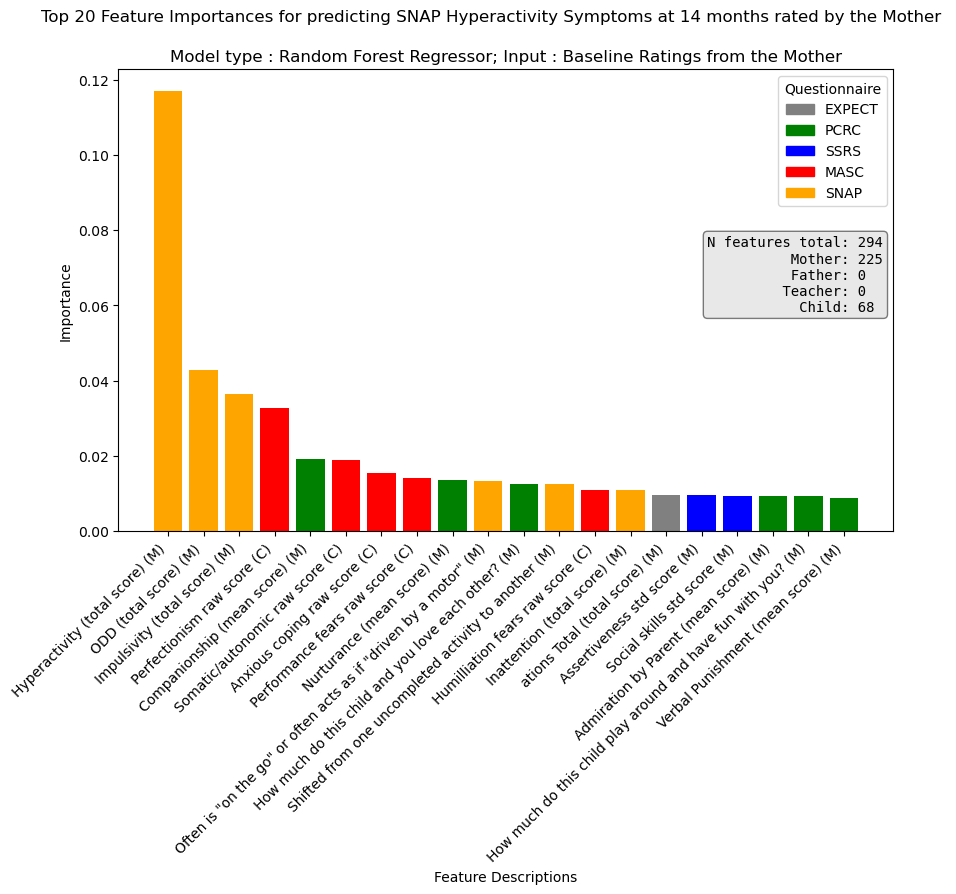

In [34]:



# Get processed feature names and importances.
processed_feature_names = best_pipeline["preprocessor"].get_feature_names_out()
# importance = pipeline.named_steps['regressor'].feature_importances_
top_n = 20
indices = np.argsort(importances)[::-1][:top_n]
top_feature_names = processed_feature_names[indices]
top_importances = importances[indices]

# Count extensions (assumes extensions is defined, e.g. extensions = ["m", "f", "t", "c", "n"])
extension_counts = {ext: sum(col.endswith(ext) for col in processed_feature_names) for ext in extensions}
print(extension_counts)

# Build a support text using plain text with aligned keys.
support_data = {
    "N features total": len(processed_feature_names),
    "Mother": extension_counts.get("m", 0),
    "Father": extension_counts.get("f", 0),
    "Teacher": extension_counts.get("t", 0),
    "Child": extension_counts.get("c", 0)
}
max_key_len = max(len(key) for key in support_data.keys())
lines = []
for key, value in support_data.items():
    # Right-align the keys so the colon lines up.
    line = "{:>{width}}: {}".format(key, value, width=max_key_len)
    lines.append(line)
support_text = "\n".join(lines)

# Define questionnaire colors.
questionnaire_colors = {
    'SNAP': 'orange',
    'SSRS': 'blue',
    'PCRC': 'green',
    'SCID': 'purple',
    'CBCL': 'lightblue',
    "MASC": "red",
    "EXPECT": "gray"
}

rater_dict = {
    "m": "the Mother", 
    "f": "the Father",
    "t": "the Teacher",
    "c": "the Child",
    "all": "All Raters"
}

def clean_description(description, questionnaires):
    # Remove a leading number and following non-letter characters.
    description = re.sub(r'^\d+[^A-Za-z]*', '', description)
    # Remove any questionnaire name (case-insensitive) at the start along with following non-letter characters.
    for q in questionnaires:
        pattern = re.compile(r'^(?i)' + re.escape(q) + r'[^A-Za-z]*')
        description = pattern.sub('', description)
    return description.strip()

def get_description(var_name, info):
    match = info[info['ElementName'].apply(lambda x: var_name in x )]
    print(var_name)
    description = match.iloc[0]['ElementDescription'] if not match.empty else var_name
    return clean_description(description, list(questionnaire_colors.keys()))

final_labels = []
bar_colors = []
questionnaires_found = set()

for feature in top_feature_names:
    # Expected format: type__questionnaire_varname_rater
    parts = feature.split('__')
    if len(parts) == 2:
        rest_parts = parts[1].split('_')
        if len(rest_parts) >= 3:
            questionnaire = rest_parts[0].upper()
            rater = rest_parts[-1].upper()
            var_name = '_'.join(rest_parts[1:-1])
            description = get_description(var_name, info)
            # If the rater is not 'C', and the description contains both Child and Parent parts,
            # extract only the Parent part (remove the literal "Parent.").
            if rater != 'C':
                parent_match = re.search(r'(?i)Parent\.\s*(.*)', description)
                if parent_match:
                    description = parent_match.group(1).strip()
            label = f"{description} ({rater})"
            final_labels.append(label)
            color = questionnaire_colors.get(questionnaire, 'grey')
            bar_colors.append(color)
            questionnaires_found.add(questionnaire)
        else:
            final_labels.append(feature)
            bar_colors.append('grey')
    else:
        final_labels.append(feature)
        bar_colors.append('grey')

# Create figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart.
ax.bar(final_labels, top_importances, color=bar_colors)
ax.set_xlabel("Feature Descriptions")
ax.set_ylabel("Importance")
ax.set_xticklabels(final_labels, rotation=45, ha='right')

# Set the titles.
title = get_fig_title(top_n, rater_dict, rater_out, n_remove_top_features, compute_perm_importances)
fig.suptitle(title)
#fig.suptitle("Top {} Feature Importances for predicting {} at 14 months rated by {}".format(
  #  top_n, fig_outcome, rater_dict[rater_out]))
ax.set_title("Model type : {}; Input : Baseline Ratings from {}".format( model_name_fig,
    rater_dict[rater_pred_fig]))

ax.set_xticks(range(len(final_labels)))
ax.set_xticklabels(final_labels, rotation=45, ha='right')
# Add the support text box (using plain text with monospace font).
ax.text(0.76,0.64, support_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='left',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

# Create a legend for the questionnaires.
legend_handles = [Patch(color=questionnaire_colors.get(q, 'grey'), label=q) for q in questionnaires_found]
ax.legend(handles=legend_handles, title="Questionnaire",loc='upper right', bbox_to_anchor=(1, 1) )

if save_fig:

    fig_name = get_name_save(outcome_name, compute_perm_importances, n_remove_top_features, ".png")
    print("Saving to path {}".format(save_path_fig))
    if not os.path.exists(save_path_fig):
        os.makedirs(save_path_fig)
    plt.savefig(Path(save_path_fig, fig_name ), bbox_inches='tight')

plt.show()

In [35]:

sorted_indices = np.argsort(importances)
top_indices = sorted_indices[-top_n:]
sorted_feature_names = processed_feature_names[sorted_indices]
#top_importances = importances[top_indices]

idx_impo_all = np.argsort(importances)[::-1][:-1]
top_feature_names_all = processed_feature_names[idx_impo_all]
top_importances_all = importances[idx_impo_all]

prefixes = ['num__','cat_str__','cat_num__', 'ord__']
pattern = re.compile(r'^(' + '|'.join(map(re.escape, prefixes)) + ')')
top_feature_names_all_short= [pattern.sub('', name) for name in top_feature_names_all]
columns = ["features","features_model" , "importances"]
importances_df = pd.DataFrame({"features": top_feature_names_all_short ,"features_model": top_feature_names_all, "importanecs": top_importances_all})
table_name = get_name_save(outcome_name +"_sorted", compute_perm_importances, n_remove_top_features, ".csv")
print(importances_df)
if save_importance_df : 
    importances_df.to_csv(Path(save_path_importances, table_name))

                                features  \
0                        snap_snahypat_m   
1                         snap_snaoddt_m   
2                        snap_snaimput_m   
3                          masc_ma21px_c   
4                        pcrc_pcrccomx_m   
..                                   ...   
242           masc_masc_physicaltotalt_c   
243  masc_masc_harmavoidperfectionismt_c   
244                         pcrc_pcc31_m   
245                         pcrc_pcc33_m   
246  masc_masc_harmavoidanxiouscopingt_c   

                               features_model  importanecs  
0                        num__snap_snahypat_m     0.116933  
1                         num__snap_snaoddt_m     0.042914  
2                        num__snap_snaimput_m     0.036343  
3                          num__masc_ma21px_c     0.032603  
4                        num__pcrc_pcrccomx_m     0.019200  
..                                        ...          ...  
242           num__masc_masc_physicaltotalt_

In [36]:
importances_df[:25]

,features,features_model,importanecs
0,snap_snahypat_m,num__snap_snahypat_m,0.116933
1,snap_snaoddt_m,num__snap_snaoddt_m,0.042914
2,snap_snaimput_m,num__snap_snaimput_m,0.036343
3,masc_ma21px_c,num__masc_ma21px_c,0.032603
4,pcrc_pcrccomx_m,num__pcrc_pcrccomx_m,0.019200
5,masc_ma12sax_c,num__masc_ma12sax_c,0.018775
6,masc_ma22acx_c,num__masc_ma22acx_c,0.015361
7,masc_ma32pfx_c,num__masc_ma32pfx_c,0.014052
8,pcrc_pcrcnurx_m,num__pcrc_pcrcnurx_m,0.013596
9,snap_snap_adhd_15_m,ord__snap_snap_adhd_15_m,0.013302


In [37]:
prefixes = ['num__','cat_str__','cat_num__', 'ord__']
pattern = re.compile(r'^(' + '|'.join(map(re.escape, prefixes)) + ')')
top_feature_names_all_short= [pattern.sub('', name) for name in top_feature_names_all]
columns = ["features","features_model" , "importances"]
importances_df = pd.DataFrame({"features": top_feature_names_all_short ,"features_model": top_feature_names_all, "importanecs": top_importances_all})
table_name = get_name_save(outcome_name +"_sorted", compute_perm_importances, n_remove_top_features, ".csv")
print(importances_df)
if save_importance_df : 
    importances_df.to_csv(Path(save_path_importances, table_name))

                                features  \
0                        snap_snahypat_m   
1                         snap_snaoddt_m   
2                        snap_snaimput_m   
3                          masc_ma21px_c   
4                        pcrc_pcrccomx_m   
..                                   ...   
242           masc_masc_physicaltotalt_c   
243  masc_masc_harmavoidperfectionismt_c   
244                         pcrc_pcc31_m   
245                         pcrc_pcc33_m   
246  masc_masc_harmavoidanxiouscopingt_c   

                               features_model  importanecs  
0                        num__snap_snahypat_m     0.116933  
1                         num__snap_snaoddt_m     0.042914  
2                        num__snap_snaimput_m     0.036343  
3                          num__masc_ma21px_c     0.032603  
4                        num__pcrc_pcrccomx_m     0.019200  
..                                        ...          ...  
242           num__masc_masc_physicaltotalt_

In [38]:
results_file_name_mean = outcome_name + "_post_hoc_ML_results_mean.csv"
results_file_name_dist = outcome_name + "_post_hoc_ML_results_dist.csv"

post_hoc_save_path = Path(save_path, "post_hoc")

In [39]:
## results table here 

params_RF = ['n_estimators', 'criterion', 'max_depth', 'max_features']
params_XGB = [ 'n_estimators', 'learning_rate','max_depth', 'max_leaves', 'tree_method' ]


cols_res_mean = ['Model Name', 
              'Mean Squared Error - Mean Across Folds', 
              'Mean Absolute Error - Mean Across Folds',
              'R² Score - Mean Across Folds', 
              'N Top Features Removed', 
              'Number of Features per Rater', 
              "Wilcoxon W",
              "P Value"]

cols_res_dist = ['Model Name', 
              'Mean Squared Error - Distribution',
              'Mean Absolute Error - Distribution',
              'R² Score - Distribution', 
              'N Top Features Removed', 
              'Number of Features per Rater',
              "Wilcoxon W",
              "P Value"]

In [40]:
n_features_removed = n_remove_top_features if n_remove_top_features is not None else 0
formatted_support = "\n".join(f"{k}: {v}" for k, v in support_data.items())

In [41]:
r2_dist

array([0.21858861, 0.10994986, 0.22424989, 0.16872278, 0.15553318])

In [42]:

new_row_mean = dict(zip(cols_res_mean, [model_name, mean_mse, mean_mae, mean_r2, n_features_removed, formatted_support, None, None]))
new_row_dist = dict(zip(cols_res_dist, [model_name, mse_dist, mae_dist, r2_dist, n_features_removed, formatted_support, None, None]))

In [43]:
new_row_dist

{'Model Name': 'RandomForestRegressor',
 'Mean Squared Error - Distribution': array([3.10091655, 2.78095918, 2.82796071, 3.3212057 , 3.20973595]),
 'Mean Absolute Error - Distribution': array([14.9917617 , 13.0356878 , 12.21078283, 18.08393716, 13.85466044]),
 'R² Score - Distribution': array([0.21858861, 0.10994986, 0.22424989, 0.16872278, 0.15553318]),
 'N Top Features Removed': 0,
 'Number of Features per Rater': 'N features total: 294\nMother: 225\nFather: 0\nTeacher: 0\nChild: 68',
 'Wilcoxon W': None,
 'P Value': None}

In [44]:
import ast
import numpy as np

def to_list_if_string(val):
    print(val, type(val))
    # If val is a string that looks like a list, convert it
    if isinstance(val, str) and (val.startswith("[")):
        print("Is STR array")
        try:
            return np.array(val)
        except (ValueError, SyntaxError):
            print("Error converting string to list.. returning value")
            pass
    return val

def rows_equal(row1, row2):
    for col in row1.index:
        val1, val2 = row1[col], row2[col]
        
        # Parse potential string lists
        val1, val2 = to_list_if_string(val1), to_list_if_string(val2)
        print(type(val1), type(val2))
        
        # Check if they're now list/array
        if isinstance(val1, (list, np.ndarray)) and isinstance(val2, (list, np.ndarray)):
            arr1, arr2 = np.array(val1), np.array(val2)
            if arr1.shape != arr2.shape or not np.all(arr1 == arr2):
                return False
        else:
            if val1 != val2:
                return False
    return True
def append_results_df(new_row, file_name_save, file_path_save):
    path_save = Path(file_path_save, file_name_save)
    columns = list(new_row.keys())
    
    if os.path.exists(path_save):
        df_result = pd.read_csv(path_save)
        if 'Unnamed: 0' in df_result.columns:
            df_result = df_result.drop(columns='Unnamed: 0')
    else:
        df_result = pd.DataFrame(columns=columns)
    
    # Convert new_row to a Series for easier row-wise comparison
    new_row_series = pd.Series(new_row)
    
    # Check if an identical row already exists
    row_matches = df_result.apply(lambda row: rows_equal(row, new_row_series), axis=1)
    
    if not row_matches.any():
        df_result = pd.concat([df_result, pd.DataFrame([new_row])], ignore_index=True)
    else:
        print("ROW ALREADY EXISTS")
    
    return df_result



In [45]:

df_result_mean = append_results_df(new_row_mean, results_file_name_mean, post_hoc_save_path)
df_result_dist = append_results_df(new_row_dist, results_file_name_dist, post_hoc_save_path)

RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
14.1276 <class 'float'>
14.4353 <class 'float'>
<class 'float'> <class 'float'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
14.1276 <class 'float'>
14.4353 <class 'float'>
<class 'float'> <class 'float'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
14.1563 <class 'float'>
14.4353 <class 'float'>
<class 'float'> <class 'float'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
14.1525 <class 'float'>
14.4353 <class 'float'>
<class 'float'> <class 'float'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
14.211 <class 'float'>
14.4353 <class 'float'>
<class 'float'> <class 'float'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
1

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_90185/4073220266.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame([new_row])], ignore_index=True)
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_90185/4073220266.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame([new_row])], ignore_index=True)


In [46]:

df_result_dist = append_results_df(new_row_dist, results_file_name_dist, post_hoc_save_path)

RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
[3.084897   2.82645457 2.80004507 3.25665866 3.17639382] <class 'str'>
Is STR array
[3.10091655 2.78095918 2.82796071 3.3212057  3.20973595] <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
[3.084897   2.82645457 2.80004507 3.25665866 3.17639382] <class 'str'>
Is STR array
[3.10091655 2.78095918 2.82796071 3.3212057  3.20973595] <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <class 'str'>
<class 'str'> <class 'str'>
[3.08695892 2.82597565 2.80994925 3.26330554 3.17744574] <class 'str'>
Is STR array
[3.10091655 2.78095918 2.82796071 3.3212057  3.20973595] <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
RandomForestRegressor <class 'str'>
RandomForestRegressor <cl

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_90185/4073220266.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame([new_row])], ignore_index=True)


In [47]:
df_result_dist

,Model Name,Mean Squared Error - Distribution,Mean Absolute Error - Distribution,R² Score - Distribution,N Top Features Removed,Number of Features per Rater,Wilcoxon W,P Value
0,RandomForestRegressor,[3.084897 2.82645457 2.80004507 3.25665866 3...,[14.49749811 13.40763937 11.81460083 17.430097...,[0.24435097 0.08455377 0.2494193 0.1987783 0...,0,N features total: 297\nMother: 296\nFather: 0\...,NaN,NaN
1,RandomForestRegressor,[3.084897 2.82645457 2.80004507 3.25665866 3...,[14.49749811 13.40763937 11.81460083 17.430097...,[0.24435097 0.08455377 0.2494193 0.1987783 0...,1,N features total: 295\nMother: 294\nFather: 0\...,5.0,0.6250
2,RandomForestRegressor,[3.08695892 2.82597565 2.80994925 3.26330554 3...,[14.49172102 13.44558313 11.87239046 17.440918...,[0.24465209 0.08196304 0.24574793 0.19828087 0...,2,N features total: 294\nMother: 293\nFather: 0\...,1.0,0.1250
3,RandomForestRegressor,[3.09223847 2.8345532 2.80578646 3.25846172 3...,[14.50098808 13.44460409 11.80828482 17.466239...,[0.24416906 0.08202989 0.24982056 0.19711692 0...,3,N features total: 293\nMother: 292\nFather: 0\...,2.0,0.1875
4,RandomForestRegressor,[3.10481025 2.82600625 2.81633733 3.26489169 3...,[14.6202886 13.45275072 11.86850738 17.573618...,[0.2379508 0.08147365 0.24599462 0.19218098 0...,4,N features total: 291\nMother: 290\nFather: 0\...,0.0,0.0625
5,RandomForestRegressor,[3.10440026 2.82270317 2.81787185 3.26720438 3...,[14.6356116 13.40469438 11.8519387 17.607710...,[0.23715212 0.08475484 0.24704723 0.19061382 0...,5,N features total: 290\nMother: 289\nFather: 0\...,3.0,0.3125
6,RandomForestRegressor,[3.10440026 2.82270317 2.81787185 3.26720438 3...,[14.6356116 13.40469438 11.8519387 17.607710...,[0.23715212 0.08475484 0.24704723 0.19061382 0...,6,N features total: 289\nMother: 288\nFather: 0\...,3.0,0.3125
7,RandomForestRegressor,[3.10578741 2.83598364 2.82105095 3.26077736 3...,[14.74887045 13.57280797 11.92060462 17.674949...,[0.23124876 0.07327639 0.24268489 0.18752303 0...,7,N features total: 288\nMother: 287\nFather: 0\...,2.0,0.1875
8,RandomForestRegressor,[3.100946 2.83432747 2.82281918 3.27586718 3...,[14.72758888 13.61753563 11.9705669 17.722112...,[0.23235801 0.07022248 0.23951079 0.18535505 0...,8,N features total: 287\nMother: 286\nFather: 0\...,1.0,0.1250
9,RandomForestRegressor,[3.10500336 2.82421596 2.82436239 3.28234358 3...,[14.77953152 13.54852843 11.95398573 17.744473...,[0.22965062 0.07493415 0.24056419 0.18432715 0...,9,N features total: 286\nMother: 285\nFather: 0\...,1.0,0.1250


In [48]:
df_result_mean

,Model Name,Mean Squared Error - Mean Across Folds,Mean Absolute Error - Mean Across Folds,R² Score - Mean Across Folds,N Top Features Removed,Number of Features per Rater,Wilcoxon W,P Value
0,RandomForestRegressor,14.1276,3.0288,0.1909,0,N features total: 297\nMother: 296\nFather: 0\...,NaN,NaN
1,RandomForestRegressor,14.1276,3.0288,0.1909,1,N features total: 295\nMother: 294\nFather: 0\...,5.0,0.6250
2,RandomForestRegressor,14.1563,3.0327,0.1891,2,N features total: 294\nMother: 293\nFather: 0\...,1.0,0.1250
3,RandomForestRegressor,14.1525,3.0346,0.1895,3,N features total: 293\nMother: 292\nFather: 0\...,2.0,0.1875
4,RandomForestRegressor,14.2110,3.0397,0.1864,4,N features total: 291\nMother: 290\nFather: 0\...,0.0,0.0625
5,RandomForestRegressor,14.1935,3.0393,0.1877,5,N features total: 290\nMother: 289\nFather: 0\...,3.0,0.3125
6,RandomForestRegressor,14.1935,3.0393,0.1877,6,N features total: 289\nMother: 288\nFather: 0\...,3.0,0.3125
7,RandomForestRegressor,14.2532,3.0348,0.1842,7,N features total: 288\nMother: 287\nFather: 0\...,2.0,0.1875
8,RandomForestRegressor,14.2810,3.0361,0.1825,8,N features total: 287\nMother: 286\nFather: 0\...,1.0,0.1250
9,RandomForestRegressor,14.2867,3.0376,0.1824,9,N features total: 286\nMother: 285\nFather: 0\...,1.0,0.1250


In [49]:
from scipy.stats import wilcoxon
if new_row_dist["N Top Features Removed"] != 0:
    r2_original_dist_str = df_result_dist.loc[
        df_result_dist["N Top Features Removed"] == 0,
        "R² Score - Distribution"
    ].iloc[0]
    r2_original_dist = np.fromstring(r2_original_dist_str.strip("[]"), sep=' ')
    w_stat, p_val = wilcoxon(r2_dist, r2_original_dist)
    print("Wilcoxon signed-rank p-value:", p_val, w_stat)
    df_result_mean.at[df_result_mean.index[-1], "Wilcoxon W"] = w_stat
    df_result_dist.at[df_result_dist.index[-1], "Wilcoxon W"] = w_stat
    
    df_result_mean.at[df_result_mean.index[-1], "P Value"] = p_val
    df_result_dist.at[df_result_dist.index[-1], "P Value"] = p_val
    



In [50]:
nrows2drop = 2
df_result_reduced_mean = df_result_mean.iloc[:df_result_mean.shape[0]-nrows2drop, :]
df_result_reduced_dist = df_result_dist.iloc[:df_result_dist.shape[0]-nrows2drop, :]

In [51]:
df_result_reduced_mean

,Model Name,Mean Squared Error - Mean Across Folds,Mean Absolute Error - Mean Across Folds,R² Score - Mean Across Folds,N Top Features Removed,Number of Features per Rater,Wilcoxon W,P Value
0,RandomForestRegressor,14.1276,3.0288,0.1909,0,N features total: 297\nMother: 296\nFather: 0\...,NaN,NaN
1,RandomForestRegressor,14.1276,3.0288,0.1909,1,N features total: 295\nMother: 294\nFather: 0\...,5.0,0.6250
2,RandomForestRegressor,14.1563,3.0327,0.1891,2,N features total: 294\nMother: 293\nFather: 0\...,1.0,0.1250
3,RandomForestRegressor,14.1525,3.0346,0.1895,3,N features total: 293\nMother: 292\nFather: 0\...,2.0,0.1875
4,RandomForestRegressor,14.2110,3.0397,0.1864,4,N features total: 291\nMother: 290\nFather: 0\...,0.0,0.0625
5,RandomForestRegressor,14.1935,3.0393,0.1877,5,N features total: 290\nMother: 289\nFather: 0\...,3.0,0.3125
6,RandomForestRegressor,14.1935,3.0393,0.1877,6,N features total: 289\nMother: 288\nFather: 0\...,3.0,0.3125
7,RandomForestRegressor,14.2532,3.0348,0.1842,7,N features total: 288\nMother: 287\nFather: 0\...,2.0,0.1875
8,RandomForestRegressor,14.2810,3.0361,0.1825,8,N features total: 287\nMother: 286\nFather: 0\...,1.0,0.1250
9,RandomForestRegressor,14.2867,3.0376,0.1824,9,N features total: 286\nMother: 285\nFather: 0\...,1.0,0.1250


In [52]:
df_result_dist

,Model Name,Mean Squared Error - Distribution,Mean Absolute Error - Distribution,R² Score - Distribution,N Top Features Removed,Number of Features per Rater,Wilcoxon W,P Value
0,RandomForestRegressor,[3.084897 2.82645457 2.80004507 3.25665866 3...,[14.49749811 13.40763937 11.81460083 17.430097...,[0.24435097 0.08455377 0.2494193 0.1987783 0...,0,N features total: 297\nMother: 296\nFather: 0\...,NaN,NaN
1,RandomForestRegressor,[3.084897 2.82645457 2.80004507 3.25665866 3...,[14.49749811 13.40763937 11.81460083 17.430097...,[0.24435097 0.08455377 0.2494193 0.1987783 0...,1,N features total: 295\nMother: 294\nFather: 0\...,5.0,0.6250
2,RandomForestRegressor,[3.08695892 2.82597565 2.80994925 3.26330554 3...,[14.49172102 13.44558313 11.87239046 17.440918...,[0.24465209 0.08196304 0.24574793 0.19828087 0...,2,N features total: 294\nMother: 293\nFather: 0\...,1.0,0.1250
3,RandomForestRegressor,[3.09223847 2.8345532 2.80578646 3.25846172 3...,[14.50098808 13.44460409 11.80828482 17.466239...,[0.24416906 0.08202989 0.24982056 0.19711692 0...,3,N features total: 293\nMother: 292\nFather: 0\...,2.0,0.1875
4,RandomForestRegressor,[3.10481025 2.82600625 2.81633733 3.26489169 3...,[14.6202886 13.45275072 11.86850738 17.573618...,[0.2379508 0.08147365 0.24599462 0.19218098 0...,4,N features total: 291\nMother: 290\nFather: 0\...,0.0,0.0625
5,RandomForestRegressor,[3.10440026 2.82270317 2.81787185 3.26720438 3...,[14.6356116 13.40469438 11.8519387 17.607710...,[0.23715212 0.08475484 0.24704723 0.19061382 0...,5,N features total: 290\nMother: 289\nFather: 0\...,3.0,0.3125
6,RandomForestRegressor,[3.10440026 2.82270317 2.81787185 3.26720438 3...,[14.6356116 13.40469438 11.8519387 17.607710...,[0.23715212 0.08475484 0.24704723 0.19061382 0...,6,N features total: 289\nMother: 288\nFather: 0\...,3.0,0.3125
7,RandomForestRegressor,[3.10578741 2.83598364 2.82105095 3.26077736 3...,[14.74887045 13.57280797 11.92060462 17.674949...,[0.23124876 0.07327639 0.24268489 0.18752303 0...,7,N features total: 288\nMother: 287\nFather: 0\...,2.0,0.1875
8,RandomForestRegressor,[3.100946 2.83432747 2.82281918 3.27586718 3...,[14.72758888 13.61753563 11.9705669 17.722112...,[0.23235801 0.07022248 0.23951079 0.18535505 0...,8,N features total: 287\nMother: 286\nFather: 0\...,1.0,0.1250
9,RandomForestRegressor,[3.10500336 2.82421596 2.82436239 3.28234358 3...,[14.77953152 13.54852843 11.95398573 17.744473...,[0.22965062 0.07493415 0.24056419 0.18432715 0...,9,N features total: 286\nMother: 285\nFather: 0\...,1.0,0.1250


In [53]:
save_results_df = True
reduced = False
if save_results_df :
    print('save')
    if reduced:
        print('reduced')
        df_result_reduced_mean.to_csv(Path(post_hoc_save_path, results_file_name_mean))
        df_result_reduced_dist.to_csv(Path(post_hoc_save_path, results_file_name_dist))
    else:
        print('full')
        df_result_dist.to_csv(Path(post_hoc_save_path, results_file_name_dist))
        df_result_mean.to_csv(Path(post_hoc_save_path, results_file_name_mean))
        
verify_mean   = pd.read_csv(Path(post_hoc_save_path, results_file_name_mean))
verify_dist   = pd.read_csv(Path(post_hoc_save_path, results_file_name_dist))



save
full


In [54]:
verify_mean

,Unnamed: 0,Model Name,Mean Squared Error - Mean Across Folds,Mean Absolute Error - Mean Across Folds,R² Score - Mean Across Folds,N Top Features Removed,Number of Features per Rater,Wilcoxon W,P Value
0,0,RandomForestRegressor,14.1276,3.0288,0.1909,0,N features total: 297\nMother: 296\nFather: 0\...,NaN,NaN
1,1,RandomForestRegressor,14.1276,3.0288,0.1909,1,N features total: 295\nMother: 294\nFather: 0\...,5.0,0.6250
2,2,RandomForestRegressor,14.1563,3.0327,0.1891,2,N features total: 294\nMother: 293\nFather: 0\...,1.0,0.1250
3,3,RandomForestRegressor,14.1525,3.0346,0.1895,3,N features total: 293\nMother: 292\nFather: 0\...,2.0,0.1875
4,4,RandomForestRegressor,14.2110,3.0397,0.1864,4,N features total: 291\nMother: 290\nFather: 0\...,0.0,0.0625
5,5,RandomForestRegressor,14.1935,3.0393,0.1877,5,N features total: 290\nMother: 289\nFather: 0\...,3.0,0.3125
6,6,RandomForestRegressor,14.1935,3.0393,0.1877,6,N features total: 289\nMother: 288\nFather: 0\...,3.0,0.3125
7,7,RandomForestRegressor,14.2532,3.0348,0.1842,7,N features total: 288\nMother: 287\nFather: 0\...,2.0,0.1875
8,8,RandomForestRegressor,14.2810,3.0361,0.1825,8,N features total: 287\nMother: 286\nFather: 0\...,1.0,0.1250
9,9,RandomForestRegressor,14.2867,3.0376,0.1824,9,N features total: 286\nMother: 285\nFather: 0\...,1.0,0.1250


In [55]:
verify_dist

,Unnamed: 0,Model Name,Mean Squared Error - Distribution,Mean Absolute Error - Distribution,R² Score - Distribution,N Top Features Removed,Number of Features per Rater,Wilcoxon W,P Value
0,0,RandomForestRegressor,[3.084897 2.82645457 2.80004507 3.25665866 3...,[14.49749811 13.40763937 11.81460083 17.430097...,[0.24435097 0.08455377 0.2494193 0.1987783 0...,0,N features total: 297\nMother: 296\nFather: 0\...,NaN,NaN
1,1,RandomForestRegressor,[3.084897 2.82645457 2.80004507 3.25665866 3...,[14.49749811 13.40763937 11.81460083 17.430097...,[0.24435097 0.08455377 0.2494193 0.1987783 0...,1,N features total: 295\nMother: 294\nFather: 0\...,5.0,0.6250
2,2,RandomForestRegressor,[3.08695892 2.82597565 2.80994925 3.26330554 3...,[14.49172102 13.44558313 11.87239046 17.440918...,[0.24465209 0.08196304 0.24574793 0.19828087 0...,2,N features total: 294\nMother: 293\nFather: 0\...,1.0,0.1250
3,3,RandomForestRegressor,[3.09223847 2.8345532 2.80578646 3.25846172 3...,[14.50098808 13.44460409 11.80828482 17.466239...,[0.24416906 0.08202989 0.24982056 0.19711692 0...,3,N features total: 293\nMother: 292\nFather: 0\...,2.0,0.1875
4,4,RandomForestRegressor,[3.10481025 2.82600625 2.81633733 3.26489169 3...,[14.6202886 13.45275072 11.86850738 17.573618...,[0.2379508 0.08147365 0.24599462 0.19218098 0...,4,N features total: 291\nMother: 290\nFather: 0\...,0.0,0.0625
5,5,RandomForestRegressor,[3.10440026 2.82270317 2.81787185 3.26720438 3...,[14.6356116 13.40469438 11.8519387 17.607710...,[0.23715212 0.08475484 0.24704723 0.19061382 0...,5,N features total: 290\nMother: 289\nFather: 0\...,3.0,0.3125
6,6,RandomForestRegressor,[3.10440026 2.82270317 2.81787185 3.26720438 3...,[14.6356116 13.40469438 11.8519387 17.607710...,[0.23715212 0.08475484 0.24704723 0.19061382 0...,6,N features total: 289\nMother: 288\nFather: 0\...,3.0,0.3125
7,7,RandomForestRegressor,[3.10578741 2.83598364 2.82105095 3.26077736 3...,[14.74887045 13.57280797 11.92060462 17.674949...,[0.23124876 0.07327639 0.24268489 0.18752303 0...,7,N features total: 288\nMother: 287\nFather: 0\...,2.0,0.1875
8,8,RandomForestRegressor,[3.100946 2.83432747 2.82281918 3.27586718 3...,[14.72758888 13.61753563 11.9705669 17.722112...,[0.23235801 0.07022248 0.23951079 0.18535505 0...,8,N features total: 287\nMother: 286\nFather: 0\...,1.0,0.1250
9,9,RandomForestRegressor,[3.10500336 2.82421596 2.82436239 3.28234358 3...,[14.77953152 13.54852843 11.95398573 17.744473...,[0.22965062 0.07493415 0.24056419 0.18432715 0...,9,N features total: 286\nMother: 285\nFather: 0\...,1.0,0.1250


Need 
- model name 
- mean MAE + list 
- mean MSE + list  
- mean R2 + list  
- Support per rater 
- perm or no perm + N perm 
- N feature removed 
- p val difference with no removal dist

Constant 
- hyperparams 
- outcome 
- input 
- thrshold drop row 
- cross val type 

In [56]:
print(model_name,  mean_mae, mean_mse, mean_r2)

RandomForestRegressor 3.0481 14.4353 0.1754


In [57]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_neg_mae', 'test_neg_mse', 'test_r2'])